In [1]:
%matplotlib notebook

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
from scipy.signal import savgol_filter
import statsmodels.api as sm
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig4_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True) 

# Hyperscope data (larva) comes with 30 Hz image aquisition frequency
aq_rate = 30

In [4]:
scatterplot_ylim_min=-1
scatterplot_ylim_max= 10

In [5]:
filename = 'Fig4_CDE'
# read the numpy array
data = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 4C, D and E. 
These plots show that decreasing light intensity from 73uW/mm2 
down to 8uW/mm2 helps with the interpretation of calcium imaging data.
The stimulus duration is 1 second and the stimulus wavelength 590nm. 

Output data is organized the following way:

1st dimension is 600. These are the datapoints 

2nd dimension is 7. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5. 
Each df/f is a repeat on the same animal 

3rd dimension is 5, one for each animal 

4th dimension is 3. These are: 8uW/mm2, 47uW/mm2 and 72uW/mm2 

5th dimension is 3. The first contains Gal4+, ATR- data, the second contains Gal4+, ATR+ data
the third contains Gal4-, ATR+

As and example, if one wants to grab Gal4+, ATR+, 8uW/mm2 data the indeces are: 
data[:, 2::,:,0,1].



# 73 uW/mm2

In [6]:
# Define colors used for this plot

colors = ['k',
          'deepskyblue',
          'magenta',
        ]

# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# First, plot light intensity 72uW/mmw 
stim_intensity = 2

for group in range(3):

    ax.plot(data[:,0,0,stim_intensity, group], median_per_animal[:,:,stim_intensity, group], 
            lw=1, zorder=1, color=colors[group], alpha=0.5)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity, group], 
            np.mean(median_per_animal[:,:,stim_intensity, group], axis=1), 
            lw=4, zorder=1, color=colors[group])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')
ax.set_ylim(-1,11)

savename = 'Fig4D_73uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [7]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*1)) # one second before start
before_end_index = start_stim

during_start_index = int(round(stop_stim-aq_rate*0.5)) # take half second before the end of the stimulus...
during_end_index = int(round(stop_stim+aq_rate*0.5)) # ...until half second after the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


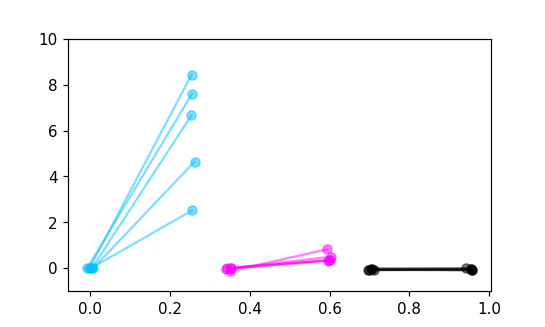

In [8]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)

stim_intensity = 2 # 72 uW/mm2
# First plot Gal4+, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[1], start_x_position=0, group=1)
# Then Gal4-, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[2], start_x_position=0.35, group=2)
# Finally Gal4+, ATR-
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0.7, group=0)

ax.set_ylim(-1,10)
savename = 'Fig4E_73uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [9]:
p_values=[]


stim_intensity = 2 # 72 uW/mm2

# median_before_stim_ATR.shape
# (5, 3, 3) # Animal, light intensity, group
print('Gal4+, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,1], 
                             median_before_stim[:,stim_intensity,1], p_values) # Gal4+, ATR+

print('Gal4-, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,2], 
                             median_before_stim[:,stim_intensity,2], p_values) # Gal4-, ATR+
print('Gal4+, ATR-')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,0], 
                             median_before_stim[:,stim_intensity,0], p_values) # Gal4+, ATR-

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

Gal4+, ATR+
lilliefors: 0.6658503164499109
T-Test
TtestResult(statistic=5.57927363063092, pvalue=0.005059600021981532, df=4)


Gal4-, ATR+
lilliefors: 0.10686939584068267
T-Test
TtestResult(statistic=4.233532104889485, pvalue=0.013332319222629936, df=4)


Gal4+, ATR-
lilliefors: 0.7964027501849873
T-Test
TtestResult(statistic=0.37570045373702415, pvalue=0.7262148362075678, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.005059600021981532, current alpha: 0.016666666666666666
significantly different with:
current p: 0.013332319222629936, current alpha: 0.025
NOT DIFFERENT!
current p: 0.7262148362075678, current alpha: 0.05


### Export stats

In [10]:
stim_intensity = 2 # 72 uW/mm2

data_export = [[median_during_stim[:,stim_intensity,1], median_before_stim[:,stim_intensity,1]],
               [median_during_stim[:,stim_intensity,2], median_before_stim[:,stim_intensity,2]],
               [median_during_stim[:,stim_intensity,0], median_before_stim[:,stim_intensity,0]]
       ]

label_list_stat_export = [['During, Gal4+, ATR+', 'Before, Gal4+, ATR+'],
                          ['During, Gal4-, ATR+', 'Before, Gal4-, ATR+'],
                          ['During, Gal4+, ATR-', 'Before, Gal4+, ATR-']]
savename = 'Fig_4E_73uW'

shared_func.export_pairwise_dependent_test(data_export, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                 Group  n      mean    median       STD       SEM  \
0  During, Gal4+, ATR+  5  5.980631  6.671894  2.145334  0.429067   
1  Before, Gal4+, ATR+  5 -0.004086 -0.000334  0.007940  0.001588   
2  During, Gal4-, ATR+  5  0.465307  0.356175  0.186096  0.037219   
3  Before, Gal4-, ATR+  5 -0.034733 -0.012994  0.054160  0.010832   
4  During, Gal4+, ATR-  5 -0.054099 -0.050545  0.033883  0.006777   
5  Before, Gal4+, ATR-  5 -0.060763 -0.073815  0.026185  0.005237   

                              95% CI on the mean  DOF statistical test  \
0        (3.0024306598292725, 8.958832076230147)  4.0       T-test rel   
1  (-0.015108233790185265, 0.006937043347211078)  NaN              NaN   
2       (0.2069646910528532, 0.7236488240988549)  4.0       T-test rel   
3    (-0.10992018563455513, 0.04045341867194623)  NaN              NaN   
4  (-0.10113618878530284, -0.007061976598839156)  4.0       T-test rel   
5  (-0.09711458368697024, -0.024412168561047144)  NaN              NaN  

# 47 uW/mm2

In [11]:
# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# First, plot light intensity 47uW/mmw 
stim_intensity = 1

for group in range(3):

    ax.plot(data[:,0,0,stim_intensity, group], median_per_animal[:,:,stim_intensity, group], 
            lw=1, zorder=1, color=colors[group], alpha=0.5)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity, group], 
            np.mean(median_per_animal[:,:,stim_intensity, group], axis=1), 
            lw=4, zorder=1, color=colors[group])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')
ax.set_ylim(-1,11)

savename = 'Fig4D_47uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<IPython.core.display.Javascript object>


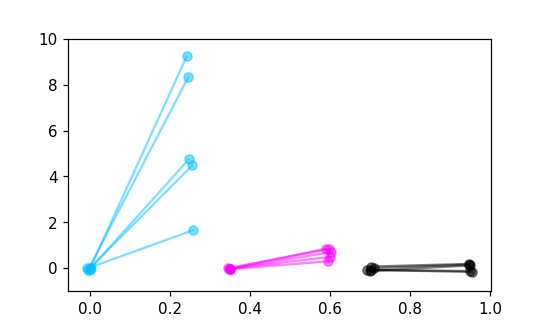

In [12]:
fig = plt.figure(figsize=(5,3))

ax = fig.add_subplot(111)

stim_intensity = 1 # 47 uW/mm2
# First plot Gal4+, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[1], start_x_position=0, group=1)
# Then Gal4-, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[2], start_x_position=0.35, group=2)
# Finally Gal4+, ATR-
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0.7, group=0)

ax.set_ylim(-1,10)
savename = 'Fig4E_47uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [13]:
p_values=[]

stim_intensity = 1 # 47 uW/mm2

# median_before_stim_ATR.shape
# (5, 3, 3) # Animal, light intensity, group
print('Gal4+, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,1], 
                             median_before_stim[:,stim_intensity,1], p_values) # Gal4+, ATR+

print('Gal4-, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,2], 
                             median_before_stim[:,stim_intensity,2], p_values) # Gal4-, ATR+
print('Gal4+, ATR-')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,0], 
                             median_before_stim[:,stim_intensity,0], p_values) # Gal4+, ATR-

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

Gal4+, ATR+
lilliefors: 0.5747695306317785
T-Test
TtestResult(statistic=4.092045410717356, pvalue=0.014950057606592753, df=4)


Gal4-, ATR+
lilliefors: 0.6017502711724065
T-Test
TtestResult(statistic=6.591444594685287, pvalue=0.002743868796729612, df=4)


Gal4+, ATR-
lilliefors: 0.6398233570035362
T-Test
TtestResult(statistic=1.2016035647379024, pvalue=0.29579431479441737, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.002743868796729612, current alpha: 0.016666666666666666
significantly different with:
current p: 0.014950057606592753, current alpha: 0.025
NOT DIFFERENT!
current p: 0.29579431479441737, current alpha: 0.05


## Export stats

In [14]:
stim_intensity = 1 # 47 uW/mm2

data_export = [[median_during_stim[:,stim_intensity,1], median_before_stim[:,stim_intensity,1]],
               [median_during_stim[:,stim_intensity,2], median_before_stim[:,stim_intensity,2]],
               [median_during_stim[:,stim_intensity,0], median_before_stim[:,stim_intensity,0]]
       ]

label_list_stat_export = [['During, Gal4+, ATR+', 'Before, Gal4+, ATR+'],
                          ['During, Gal4-, ATR+', 'Before, Gal4-, ATR+'],
                          ['During, Gal4+, ATR-', 'Before, Gal4+, ATR-']]
savename = 'Fig_4E_47uW'

shared_func.export_pairwise_dependent_test(data_export, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                 Group  n      mean    median       STD       SEM  \
0  During, Gal4+, ATR+  5  5.692381  4.742279  2.770474  0.554095   
1  Before, Gal4+, ATR+  5 -0.035403 -0.016999  0.035851  0.007170   
2  During, Gal4-, ATR+  5  0.631070  0.694959  0.210510  0.042102   
3  Before, Gal4-, ATR+  5 -0.027369 -0.029692  0.014445  0.002889   
4  During, Gal4+, ATR-  5  0.031376  0.116159  0.148225  0.029645   
5  Before, Gal4+, ATR-  5 -0.042679 -0.079595  0.069097  0.013819   

                              95% CI on the mean  DOF statistical test  \
0        (1.8463471923063683, 9.538415105921194)  4.0       T-test rel   
1   (-0.08517214379709166, 0.014365301552070914)  NaN              NaN   
2       (0.3388345938698356, 0.9233050826223921)  4.0       T-test rel   
3  (-0.04742206814999694, -0.007315910005047676)  NaN              NaN   
4     (-0.1743930992094027, 0.23714534453266856)  4.0       T-test rel   
5    (-0.1386001680368156, 0.053243078632710654)  NaN              NaN  

# 8 uW/mm2

In [15]:
# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# First, plot light intensity 8uW/mmw 
stim_intensity = 0

for group in range(3):
    ############ CONTINIUE HERE

    ax.plot(data[:,0,0,stim_intensity, group], median_per_animal[:,:,stim_intensity, group], 
            lw=1, zorder=1, color=colors[group], alpha=0.5)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity, group], 
            np.mean(median_per_animal[:,:,stim_intensity, group], axis=1), 
            lw=4, zorder=1, color=colors[group])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')
ax.set_ylim(-1,11)

savename = 'Fig4D_8uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<IPython.core.display.Javascript object>


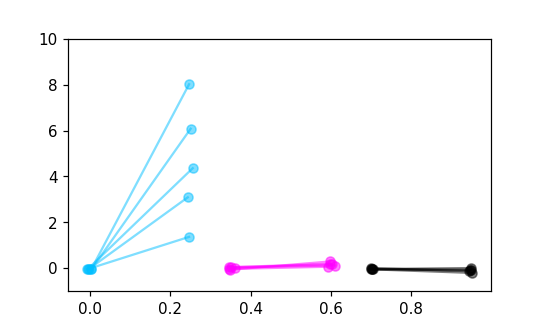

In [16]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)

stim_intensity = 0 # 8 uW/mm2
# First plot Gal4+, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[1], start_x_position=0, group=1)
# Then Gal4-, ATR+
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[2], start_x_position=0.35, group=2)
# Finally Gal4+, ATR-
shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0.7, group=0)

ax.set_ylim(-1,10)
savename = 'Fig4E_8uW.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [17]:
p_values=[]


stim_intensity = 0 # 8 uW/mm2

# median_before_stim_ATR.shape
# (5, 3, 3) # Animal, light intensity, group
print('Gal4+, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,1], 
                             median_before_stim[:,stim_intensity,1], p_values) # Gal4+, ATR+
print('Gal4-, ATR+')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,2], 
                             median_before_stim[:,stim_intensity,2], p_values) # Gal4-, ATR+
print('Gal4+, ATR-')
shared_func.pairwise_t_tests(median_during_stim[:,stim_intensity,0], 
                             median_before_stim[:,stim_intensity,0], p_values) # Gal4+, ATR-


print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

Gal4+, ATR+
lilliefors: 0.99
T-Test
TtestResult(statistic=3.994461979781472, pvalue=0.016204596414033764, df=4)


Gal4-, ATR+
lilliefors: 0.07067840797061674
T-Test
TtestResult(statistic=3.231626690554703, pvalue=0.031926253116948494, df=4)


Gal4+, ATR-
lilliefors: 0.5594742502975039
T-Test
TtestResult(statistic=-1.711738213120828, pvalue=0.16211042223919658, df=4)


Holms-Bonferroni correction:
significantly different with:
current p: 0.016204596414033764, current alpha: 0.016666666666666666
NOT DIFFERENT!
current p: 0.031926253116948494, current alpha: 0.025
NOT DIFFERENT!
current p: 0.16211042223919658, current alpha: 0.05


In [18]:
stim_intensity = 0 # 8 uW/mm2

data_export = [[median_during_stim[:,stim_intensity,1], median_before_stim[:,stim_intensity,1]],
               [median_during_stim[:,stim_intensity,2], median_before_stim[:,stim_intensity,2]],
               [median_during_stim[:,stim_intensity,0], median_before_stim[:,stim_intensity,0]]
       ]

label_list_stat_export = [['During, Gal4+, ATR+', 'Before, Gal4+, ATR+'],
                          ['During, Gal4-, ATR+', 'Before, Gal4-, ATR+'],
                          ['During, Gal4+, ATR-', 'Before, Gal4+, ATR-']]
savename = 'Fig_4E_8uW'

shared_func.export_pairwise_dependent_test(data_export, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                 Group  n      mean    median       STD       SEM  \
0  During, Gal4+, ATR+  5  4.583826  4.360100  2.313281  0.462656   
1  Before, Gal4+, ATR+  5 -0.040571 -0.042398  0.011089  0.002218   
2  During, Gal4-, ATR+  5  0.160820  0.167290  0.077281  0.015456   
3  Before, Gal4-, ATR+  5 -0.002505  0.012965  0.043007  0.008601   
4  During, Gal4+, ATR-  5 -0.101729 -0.094623  0.070084  0.014017   
5  Before, Gal4+, ATR-  5 -0.038402 -0.044272  0.021477  0.004295   

                               95% CI on the mean  DOF statistical test  \
0         (1.3724776757432418, 7.795174135359027)  4.0       T-test rel   
1  (-0.055964450432237925, -0.025176724414000762)  NaN              NaN   
2      (0.053536918786328325, 0.2681040374046665)  4.0       T-test rel   
3     (-0.06220892703453573, 0.05719841048774309)  NaN              NaN   
4   (-0.19902017729165788, -0.004436982212501425)  4.0       T-test rel   
5   (-0.06821742836684291, -0.008586845436615559)  NaN            